In [60]:
import pandas as pd
import requests
from pathlib import Path
import recordlinkage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib

# Dataset
- https://hpi.de/naumann/projects/repeatability/datasets/restaurants-dataset.html
- Available in tab separated value (TSV) format. (864 objects - TSV format)
    - Same version, with lower-cased values and with special character removed. (864 objects - TSV format)
- Duplicates
    - A list of all provided duplicates. (112 objects - TSV format)
- Non-duplicates
    - We generate non-duplicate pairs by following a systematic approach. (1,120 objects - TSV format)
    - Using an updated, further simplified approach across datasets. (1,120 objects - TSV format)
- Source: https://sourceforge.net/projects/secondstring/

In [2]:
data_dir = Path('data')
if not data_dir.exists():
    data_dir.mkdir()

In [20]:
def download_and_load(url: str, data_dir: Path) -> pd.DataFrame:
    if not data_dir.exists():
        data_dir.mkdir()
    data = requests.get(url, stream=True)
    file_name = url.split('/')[-1]
    with open(data_dir / Path(file_name), 'wb') as f:
        f.write(data.content)
    return pd.read_csv(data_dir / Path(file_name), sep='\t')

In [34]:
restaurant_df = download_and_load('https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/projekte/repeatability/Restaurants/restaurants.tsv', data_dir / Path('restaurant'))
restaurant_df = restaurant_df.set_index('id')

In [22]:
restaurant_df.sample(3)

,id,name,address,city,phone,type
302,303,boca chica,13 1st ave. near 1st st.,new york,212/473-0108,latin american
30,31,the palm,9001 santa monica blvd.,los angeles,310/550-8811,american
653,654,brighton coffee shop,9600 brighton way,beverly hills,310-276-7732,coffee shops


In [23]:
duplicate_df = download_and_load('https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/projekte/repeatability/Restaurants/restaurants_DPL.tsv', data_dir / Path('restaurant'))

In [24]:
duplicate_df.sample(3)

,id1,id2
39,79,80
21,43,44
61,123,124


In [25]:
non_duplicate_df = download_and_load('https://hpi.de/fileadmin/user_upload/fachgebiete/naumann/projekte/repeatability/Restaurants/restaurants_NDPL.tsv', data_dir / Path('restaurant'))

In [26]:
non_duplicate_df.sample(3)

,id1,id2
965,454,468
736,424,789
105,207,265


# Indexing / Creating Record Pairs

In [17]:
indexer = recordlinkage.Index()
indexer.block('city')
candidate_links = indexer.index(restaurant_df)

In [18]:
len(candidate_links)

57943

In [30]:
cols = restaurant_df.columns
cols = cols[1:]
cols

Index(['name', 'address', 'city', 'phone', 'type'], dtype='object')

In [31]:
compare = recordlinkage.Compare()
for c in cols:
    compare.string(c, c, method='jarowinkler', threshold=0.85, label=c)

In [35]:
positive_pairs = [(row['id1'], row['id2']) for index, row in duplicate_df.iterrows()]

In [37]:
positive_features = compare.compute(pd.MultiIndex.from_tuples(positive_pairs), restaurant_df)

In [38]:
positive_features.sample(3)

,,name,address,city,phone,type
151,152,1.0,1.0,1.0,1.0,0.0
133,134,1.0,1.0,1.0,1.0,0.0
95,96,1.0,0.0,1.0,1.0,0.0


In [39]:
positive_features['is_duplicate'] = 1

In [40]:
negative_pairs = [(row['id1'], row['id2']) for index, row in non_duplicate_df.iterrows()]

In [41]:
negative_features = compare.compute(pd.MultiIndex.from_tuples(negative_pairs), restaurant_df)

In [42]:
negative_features.sample(3)

,,name,address,city,phone,type
324,372,0.0,0.0,1.0,0.0,0.0
436,655,0.0,0.0,0.0,0.0,0.0
208,269,0.0,0.0,0.0,0.0,0.0


In [43]:
negative_features['is_duplicate'] = 0

In [44]:
features = pd.concat([positive_features, negative_features])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('is_duplicate', axis=1), features['is_duplicate'], test_size=0.2, random_state=42)

In [48]:
match_indices = y_train[y_train == 1].index
match_index = pd.MultiIndex.from_tuples(match_indices)

In [49]:
classifier = recordlinkage.LogisticRegressionClassifier()
classifier.fit(X_train, match_indices)

In [50]:
predictions = classifier.predict(X_test)

In [51]:
predicted_matches = pd.Series(0, index=X_test.index)
predicted_matches.loc[predictions] = 1

In [54]:
print(classification_report(y_test, predicted_matches))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       226
           1       1.00      0.90      0.95        21

    accuracy                           0.99       247
   macro avg       1.00      0.95      0.97       247
weighted avg       0.99      0.99      0.99       247


In [55]:
probabilities = classifier.prob(X_test)

<Axes: ylabel='Frequency'>

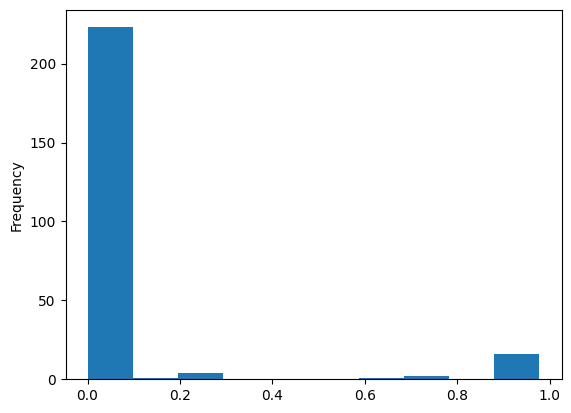

In [63]:
probabilities.plot.hist()